## Data Preparation

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
# Import relevant packages and set device to CUDA if available

# Torch class
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import functional as F, InterpolationMode
import gc

# XAI class
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import deprocess_image

# Image related class
import cv2
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Custom dataset class
from utilities import datasets

# Other packages
import numpy as np
import pandas as pd
import os
import datetime
import warnings
import copy
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Exploration

## How are the annotations represented?
- We see that the pixels with value (128, 255, 192) in the RGB channel correspond to weeds, and other pixels are crop with different color
- Detail of color code in RGB is in **dataset.py**, you can check out there
- the background is black for training and visualization purposes.

Color code for **CropsOrWeed9**


In [ ]:

# DATASETS['CropsOrWeed9'] = Dataset({
#     0: ('Maize', (255, 0, 0), [1, 2, 3, 4, 5, 6]),
#     1: ('Sugar beet', (255, 85, 0), [7, 8, 9, 10, 11, 12]),
#     2: ('Soy', (42, 255, 0), [94]),
#     3: ('Sunflower', (85, 0, 255), [24]),
#     4: ('Potato', (0, 255, 85), [18]),
#     5: ('Pea', (255, 170, 0), [13]),
#     6: ('Bean', (255, 0, 170), [26, 27]),
#     7: ('Pumpkin', (170, 255, 0), [15]),
#     8: ('Weed', (128, 255, 192),
#         [31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86, 32, 29, 33, 37, 49, 30, 44, 66, 87, 89, 91, 61, 79, 34, 41, 52, 35,
#          36, 78, 38, 39, 71, 72, 88, 42, 45, 70, 47, 51, 54, 58, 60, 80, 83, 96, 22, 63, 85, 56, 57, 64, 77, 50, 59, 67,
#          76])})

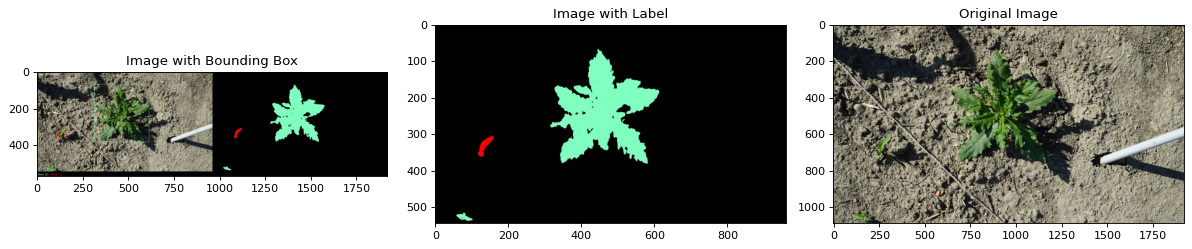

In [9]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 8), dpi=80)  # 1 row, 3 columns

# Display image with both bounding box and label
single_img_bbox_path = "./visualization/CropsOrWeed9/CropsOrWeed9/both/vwg-0259-0001.jpg"
axes[0].imshow(io.imread(single_img_bbox_path))
axes[0].set_title("Image with Bounding Box")  # Set title for clarity

# Display image with label
single_img_label_path = "./visualization/CropsOrWeed9/CropsOrWeed9/only_label/vwg-0259-0001.jpg"
axes[1].imshow(io.imread(single_img_label_path))
axes[1].set_title("Image with Label")

# Display original image
single_img_path = "./dataset/images/vwg-0259-0001.jpg"
axes[2].imshow(io.imread(single_img_path))
axes[2].set_title("Original Image")

# Adjust spacing between subplots (optional)
plt.tight_layout()

# Show the plot
plt.show()

#  Setup Dataset


## Datset class


In [ ]:
# Testing the custom dataset class
target_size = (224, 224)
img = io.imread('./dataset/images/vwg-0259-0001.jpg')
img = Image.fromarray(img).convert("RGB")
img = img.resize(target_size)
img_tensor = F.pil_to_tensor(img)/255.0
print(img_tensor.shape)
img_tensor = img_tensor.permute(2,0,1)
img_tensor.shape

torch.Size([3, 224, 224])


torch.Size([224, 3, 224])

In [13]:
class WeedCropDataset(torch.utils.data.Dataset):
    def __init__(self, images_list, annotations_list, transform=None, target_size=(224, 224)):
      self.images=images_list
      self.annotations=annotations_list
      print('Annotations: ' + str(self.annotations))
      print('Images: '+ str(self.images))
      self.transform = transform
      self.target_size = target_size

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      # Image preprocessing
      img = io.imread(self.images[idx])
      img = Image.fromarray(img).convert("RGB")
      img = img.resize(self.target_size)
      img_tensor = F.pil_to_tensor(img) / 255.0 # normalize to values between 0 and 1

      # Tensor preprocessing
      annotation = io.imread(self.annotations[idx])
      annotation = Image.fromarray(annotation)
      annotation = annotation.resize(self.target_size, Image.NEAREST)
      annotation_tensor = F.pil_to_tensor(annotation).squeeze(0).long()

      if self.transform:
            img_tensor = self.transform(img_tensor)
      sample = {'img_tensor': img_tensor, 'annotation_tensor': annotation_tensor}
      return sample



In [14]:
target_size = (224, 224)
annotation = io.imread('./dataset/labelIds/CropsOrWeed9/ave-0007-0007.png')
annotation = Image.fromarray(annotation)
annotation = annotation.resize(target_size, Image.NEAREST)
annotation_tensor = F.pil_to_tensor(annotation) / 1.0
annotation_tensor = annotation_tensor.squeeze(0)
annotation_tensor.shape

torch.Size([224, 224])

## Read Dataset and split train/test images


In [15]:
# Generate fullpath of images and annotations
def create_file_path(images_dir,annotations_dir):
	# Create images.txt (no trailing newline)
	with open("images.txt", "w") as f:
		img_fullpaths = [os.path.join(images_dir, filename) for filename in os.listdir(images_dir) if filename.endswith(".jpg")]
		f.write("\n".join(img_fullpaths))  # Join with newlines, no trailing newline
	print('Image path files created')
	print("Length of images: " + str(len(img_fullpaths)))
	print()

	# Create annotations.txt (no trailing newline)
	with open("annotations.txt", "w") as f:
		anno_fullpaths = [os.path.join(annotations_dir, filename) for filename in os.listdir(annotations_dir) if filename.endswith(".png")]
		f.write("\n".join(anno_fullpaths))  # Join with newlines, no trailing newline
	print('Annotation path files created')
	print("Length of annotations: " + str(len(anno_fullpaths)))
 
	return img_fullpaths,anno_fullpaths


def custom_sort_by_filename(filenames):
    def extract_name(filename):
        return os.path.splitext(os.path.basename(filename))[0]

    return sorted(filenames, key=extract_name)

def find_matching_annotation_image(img_fullpaths, anno_fullpaths):
	dict_annotations = {}
	for path in anno_fullpaths:
		filename=os.path.splitext(os.path.basename(path))[0]
		dict_annotations[filename]=path
		
		
	matching_image_annotations=list()
	for path in img_fullpaths:
		filename=os.path.splitext(os.path.basename(path))[0]	
		if filename in dict_annotations:
			matching_image_annotations.append(dict_annotations[filename])
      
	return matching_image_annotations, dict_annotations

def remove_images_without_annotation(img_fullpaths, dict_annotations):
	subset_images = list()
	# Remove unmatched images
	for path in img_fullpaths:
		filename=os.path.splitext(os.path.basename(path))[0]
		if filename in dict_annotations:
			subset_images.append(path)
	return subset_images

In [16]:
# Create paths with image and annotation paths
annotations_dir = "./dataset/labelIds/CropsOrWeed9"
images_dir = "./dataset/images"

img_fullpaths, anno_fullpaths= create_file_path(images_dir,annotations_dir)
subset_anno_fullpaths, dict_annotations=find_matching_annotation_image(img_fullpaths,anno_fullpaths)
subset_image_fullpaths=remove_images_without_annotation(img_fullpaths,dict_annotations)


print("\nLength of subset images: " + str(len(subset_image_fullpaths)))
print("Length of subset annotations: " + str(len(subset_anno_fullpaths)))

print(subset_image_fullpaths[-1])
print(subset_anno_fullpaths[-1])

Image path files created
Length of images: 6034

Annotation path files created
Length of annotations: 7705

Length of subset images: 5968
Length of subset annotations: 5968
./dataset/images\vwg-1361-0009.jpg
./dataset/labelIds/CropsOrWeed9\vwg-1361-0009.png


In [17]:
# Load the dataset
transform=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
dataset = WeedCropDataset(subset_image_fullpaths, subset_anno_fullpaths, transform=transform)

# split into training and testing data
split_percent=0.9
train_len = int(split_percent * len(dataset))
test_len = len(dataset) - train_len
train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
print('train set length: ' + str(len(train_set)))
print('test set length: ' + str(len(test_set)))


Annotations: ['./dataset/labelIds/CropsOrWeed9\\ave-0337-0006.png', './dataset/labelIds/CropsOrWeed9\\ave-0337-0007.png', './dataset/labelIds/CropsOrWeed9\\ave-0337-0008.png', './dataset/labelIds/CropsOrWeed9\\ave-0337-0009.png', './dataset/labelIds/CropsOrWeed9\\ave-0337-0010.png', './dataset/labelIds/CropsOrWeed9\\ave-0338-0008.png', './dataset/labelIds/CropsOrWeed9\\ave-0338-0011.png', './dataset/labelIds/CropsOrWeed9\\ave-0339-0002.png', './dataset/labelIds/CropsOrWeed9\\ave-0339-0003.png', './dataset/labelIds/CropsOrWeed9\\ave-0339-0005.png', './dataset/labelIds/CropsOrWeed9\\ave-0339-0009.png', './dataset/labelIds/CropsOrWeed9\\ave-0339-0011.png', './dataset/labelIds/CropsOrWeed9\\ave-0340-0002.png', './dataset/labelIds/CropsOrWeed9\\ave-0340-0003.png', './dataset/labelIds/CropsOrWeed9\\ave-0340-0004.png', './dataset/labelIds/CropsOrWeed9\\ave-0340-0005.png', './dataset/labelIds/CropsOrWeed9\\ave-0340-0006.png', './dataset/labelIds/CropsOrWeed9\\ave-0340-0007.png', './dataset/lab

# Training Models

## Utilities Class

In [18]:
def calculate_class_weights_vectorized(dataloader, num_classes, device):
    """Calculates class weights using vectorized operations."""
    frequencies = torch.zeros(num_classes, device=device)
    total_pixels = 0

    for batch in dataloader:
        masks = batch['annotation_tensor'].to(device)
        batch_size, H, W = masks.shape

        for c in range(num_classes):
            frequencies[c] += torch.sum(masks == c)

        total_pixels += batch_size * H * W

    frequencies = torch.where(frequencies == 0, torch.tensor(1.0, device=device), frequencies)

    weights = total_pixels / frequencies
    weights = weights / torch.sum(weights)

    return weights


In [19]:
# Optimizer weight to address class imbalance, only use calculate_class_weights_vectorized 
# And run once to get the weights
weights=[1.9525e-02, 1.0258e-02, 7.6792e-02, 1.2071e-01, 1.4754e-01, 3.9153e-01,
        1.5924e-01, 6.9968e-02, 4.3633e-03, 8.4037e-05]
weights=torch.tensor(weights).to(device)
len(weights)

10

In [20]:
def train_model(net, 
                dataloader, 
                is_unet_model=False, 
                epochs=1, 
                start_epoch=0, 
                lr=0.01, 
                decay=0.0005,
                verbose=1, 
                print_every=1, 
                state=None, 
                schedule={},
                optimizer_weight=None, # Default Pre-calculated Class weights
                checkpoint_path=None,
                gradient_accumulation_steps=4, # Use gradient accumulation to simulate larger batch sizes
                device="cuda"):
    
    torch.cuda.empty_cache()
    gc.collect()
    net.to(device)
    net.train()
    losses = []
    
    print(f"Class weights: {weights}")
    criterion = nn.CrossEntropyLoss(weight=weights) # 9 is a background class
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print(f"Learning rate: {schedule[epoch]}")
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    # Main start training loop
    for epoch in range(start_epoch, epochs):
        torch.cuda.empty_cache()
        net.train()
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print(f"Learning rate: {schedule[epoch]}")
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            images, annotations = batch['img_tensor'], batch['annotation_tensor']

            images = images.to(device)
            annotations = annotations.to(device)

            outputs = net(images)
            if is_unet_model:
                loss = criterion(outputs, annotations)
            else:
                loss = criterion(outputs['out'], annotations)

            loss = loss / gradient_accumulation_steps  # Scale loss

            loss.backward()

            if (i + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()  # Clear gradients
                losses.append(loss.item() * gradient_accumulation_steps) # Store the actual loss
                sum_loss += loss.item() * gradient_accumulation_steps

                if i % print_every == print_every - 1:
                    if verbose:
                        print(f'[Epoch {epoch}, Batch {i + 1}] loss: {sum_loss / print_every:.3f}')
                    sum_loss = 0.0
        
        # Save checkpoint after each epoch
        if checkpoint_path:
            state = {'epoch': epoch + 1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            now = datetime.datetime.now()
            timestamp = now.strftime("%Y%m%d_%H%M")
            save_path = os.path.join(checkpoint_path, f'{timestamp}checkpoint_{(epoch + 1)}.pkl')

            directory = os.path.dirname(save_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save(state, save_path)

    return losses

## Split train/test dataset

In [21]:
# define dataloaders
batch_size=16
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

print('trainloader length: ' + str(len(trainloader)))
print('testloader length: ' + str(len(testloader)))

trainloader length: 336
testloader length: 38


In [22]:
target_size = (224, 224)
img = io.imread('./dataset/labelIds/CropsOrWeed9/vwg-0266-0017.png')
img = Image.fromarray(img)
img = img.resize(target_size, Image.NEAREST)

# To numpy
img = np.array(img)

unique_values, counts = np.unique(img, return_counts=True)
a=dict(zip(unique_values, counts))

print("Unique values and their counts:")
for value, count in a.items():
    print(f"Value: {value}, Count: {count}")

Unique values and their counts:
Value: 1, Count: 100
Value: 8, Count: 1486
Value: 9, Count: 48590


In [ ]:
decay = 0.0005
lr = 0.0001

for i, batch in enumerate(trainloader, 0):
    
	# loss_fn = nn.CrossEntropyLoss()
	# images, annotations = batch['img_tensor'], batch['annotation_tensor']
	# print("annotation shape", annotations.shape)
	# print("annotation type",type(annotations))
	# print("images shape", images.shape)

	# images=images.to(device)
	# annotations=annotations.to(device)
 
	# outputs = fcnresnet50(images)['out']
 
	# print("outputs shape", outputs.shape)
 
	# loss = criterion(outputs, annotations)
	# # loss.backward()
	# print(loss)

	# optimizer = optim.Adam(fcnresnet50.parameters(), lr=lr, weight_decay=decay)
	# optimizer.load_state_dict(fcnresnet50['optimizer'])
	# optimizer.zero_grad()


	# outputs = net(images)
	# if is_unet_model:
	# 	loss = criterion(outputs, annotations)
	# else:
	# 	loss = criterion(outputs['out'], annotations)
	# loss.backward()
	# optimizer.step()

	# losses.append(loss.item())
	# sum_loss += loss.item()
	break
    

annotation shape torch.Size([2, 224, 224])
annotation type <class 'torch.Tensor'>
images shape torch.Size([2, 3, 224, 224])
outputs shape torch.Size([2, 10, 224, 224])
tensor(2.2815, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


## Create number class and color code

In [23]:
dataset_name='CropsOrWeed9'
labels = copy.deepcopy(datasets.DATASETS[dataset_name])
labels.labels[len(labels.labels)]=('Background', (0, 0, 0)) 
num_class=len(labels.labels)

print("Total class of dataset: ", num_class)
print("\nLabel of dataset")
for key, value in labels.labels.items():
	print(key, value)

Total class of dataset:  10

Label of dataset
0 ('Maize', (255, 0, 0), 0)
1 ('Sugar beet', (255, 85, 0), 1)
2 ('Soy', (42, 255, 0), 2)
3 ('Sunflower', (85, 0, 255), 3)
4 ('Potato', (0, 255, 85), 4)
5 ('Pea', (255, 170, 0), 5)
6 ('Bean', (255, 0, 170), 6)
7 ('Pumpkin', (170, 255, 0), 7)
8 ('Weed', (128, 255, 192), 8)
9 ('Background', (0, 0, 0))


## Train FCN-ResNet-50

In [119]:
# change classifier to predict only n classes in dataset
fcnresnet50 = models.segmentation.fcn_resnet50(pretrained=True, progress=True)
fcnresnet50.classifier[4] = nn.Conv2d(512, num_class, kernel_size=(1, 1), stride=(1, 1))
fcnresnet50.aux_classifier[4] = nn.Conv2d(256, num_class, kernel_size=(1, 1), stride=(1, 1))
fcnresnet50.to(device)
print("Models modified successfully") 

Models modified successfully


In [ ]:
schedule={0:.001,2:.0001}
model_name='fcnresnet50'
checkpoints = f'./checkpoints/{model_name}'
lr=0.001
epochs=3
print_every_batch=10
is_unet_model=False
gradient_accumulation_steps=4

losses = train_model(fcnresnet50,
               trainloader,
               is_unet_model=is_unet_model,
               print_every=print_every_batch,
               schedule=schedule, 
               checkpoint_path=checkpoints, 
               gradient_accumulation_steps=gradient_accumulation_steps,
               lr=lr, 
               epochs=epochs)

Learning rate: 0.001
[Epoch 0, Batch 20] loss: 0.992
[Epoch 0, Batch 40] loss: 0.497
[Epoch 0, Batch 60] loss: 0.260
[Epoch 0, Batch 80] loss: 0.143
[Epoch 0, Batch 100] loss: 0.098
[Epoch 1, Batch 20] loss: 0.081
[Epoch 1, Batch 40] loss: 0.050
[Epoch 1, Batch 60] loss: 0.049
[Epoch 1, Batch 80] loss: 0.051
[Epoch 1, Batch 100] loss: 0.053
Learning rate: 0.0001
[Epoch 2, Batch 20] loss: 0.056
[Epoch 2, Batch 40] loss: 0.036
[Epoch 2, Batch 60] loss: 0.039
[Epoch 2, Batch 80] loss: 0.045
[Epoch 2, Batch 100] loss: 0.048


## Train Google DeepLabv3

In [24]:
# change classifier to predict only n classes in dataset
deeplabv3 = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
deeplabv3.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, 3, padding=1, bias=False),  # Adjust channels if needed
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, num_class, 1)  # Output channels = num_class
)
deeplabv3.aux_classifier = nn.Sequential(
    nn.Conv2d(1024, 256, 3, padding=1, bias=False), # Adjust channels if needed
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, num_class, 1)  # Output channels = num_class
)
deeplabv3.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [177]:

schedule={0:.001,2:.0001,4:.00001}
model_name='deeplabv3'
checkpoints = f'./checkpoints/{model_name}'
lr=0.001
epochs=6
print_every_batch=20
is_unet_model=False
gradient_accumulation_steps=4
weight_decay=0.0001



losses = train_model(deeplabv3,
               trainloader,
               is_unet_model=is_unet_model,
               print_every=print_every_batch,
               schedule=schedule,
               optimizer_weight=weights,
               checkpoint_path=checkpoints, 
               decay=weight_decay,
               gradient_accumulation_steps=gradient_accumulation_steps,
               lr=lr, 
               epochs=epochs)

Class weights: tensor([1.9525e-02, 1.0258e-02, 7.6792e-02, 1.2071e-01, 1.4754e-01, 3.9153e-01,
        1.5924e-01, 6.9968e-02, 4.3633e-03, 8.4037e-05], device='cuda:0')
Learning rate: 0.001
[Epoch 0, Batch 20] loss: 0.700
[Epoch 0, Batch 40] loss: 0.630
[Epoch 0, Batch 60] loss: 0.558
[Epoch 0, Batch 80] loss: 0.511
[Epoch 0, Batch 100] loss: 0.537
[Epoch 0, Batch 120] loss: 0.513
[Epoch 0, Batch 140] loss: 0.453
[Epoch 0, Batch 160] loss: 0.479
[Epoch 0, Batch 180] loss: 0.397
[Epoch 0, Batch 200] loss: 0.601
[Epoch 0, Batch 220] loss: 0.440
[Epoch 0, Batch 240] loss: 0.370
[Epoch 0, Batch 260] loss: 0.412
[Epoch 0, Batch 280] loss: 0.438
[Epoch 0, Batch 300] loss: 0.469
[Epoch 0, Batch 320] loss: 0.324
[Epoch 1, Batch 20] loss: 0.368
[Epoch 1, Batch 40] loss: 0.358
[Epoch 1, Batch 60] loss: 0.452
[Epoch 1, Batch 80] loss: 0.334
[Epoch 1, Batch 100] loss: 0.394
[Epoch 1, Batch 120] loss: 0.324
[Epoch 1, Batch 140] loss: 0.317
[Epoch 1, Batch 160] loss: 0.307
[Epoch 1, Batch 180] loss:

# Evaluatte Models

## Utilities Class

In [25]:
class SegmentationModelOutputWrapper(torch.nn.Module):
	def __init__(self, model): 
		super(SegmentationModelOutputWrapper, self).__init__()
		self.model = model
        
	def forward(self, x):
		return self.model(x)["out"]

	def get_model(self):
		return self.model

class SemanticSegmentationTarget:
	def __init__(self, category, mask):
		self.category = category
		
		if type(mask) == np.ndarray:
			self.mask = torch.from_numpy(mask)
		else:
			self.mask = mask.float()

	def __call__(self, model_output):
		return (model_output[self.category, :, : ] * self.mask).sum()

In [26]:
def calculate_metrics_for_masks(mask1, mask2):
    """Calculates IoU, precision, recall, and F1 score for two masks in one function."""
    intersection = torch.logical_and(mask1, mask2).sum().item()
    union = torch.logical_or(mask1, mask2).sum().item()
    mask1_sum = mask1.sum().item()
    mask2_sum = mask2.sum().item()

    iou = intersection / union if union > 0 else 0.0
    precision = intersection / mask1_sum if mask1_sum > 0 else 0.0
    recall = intersection / mask2_sum if mask2_sum > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return iou, precision, recall, f1_score


In [ ]:
def mask_top_percent_gray(image, percent):
    """Masks the top 'percent' of values in a grayscale image.

    Args:
        image (torch.Tensor): The grayscale image tensor (H, W) or (1, H, W).
        percent (float): The percentage of top values to mask (0.0-1.0).

    Returns:
        torch.Tensor: The masked grayscale image tensor.
    """

    if image.ndim == 2:
        h, w = image.shape
    elif image.ndim == 3:
        _, h, w = image.shape  # Assuming the first dimension is a channel or batch dimension
    else:
        raise ValueError("Image tensor must be 2D (H, W) or 3D (C, H, W).")

    flat_image = image.view(-1)  # Flatten the image tensor

    # Calculate the threshold value based on the percentile
    threshold = torch.quantile(flat_image.float(), 1 - percent)

    # Create the mask: True for values above the threshold, False otherwise
    mask = flat_image >= threshold

    # Reshape the mask to match the original image shape
    mask = mask.view(image.shape)

    return mask

def calculate_deletion_drop(model, images, grayscale_cam, target_class_index, original_prob_avg, top_percent=0.2):
    """Calculates the deletion drop percentage.

    Args:
        model (torch.nn.Module): The PyTorch model.
        images (torch.Tensor): 4D image tensor (B, C, H, W).
        grayscale_cam (torch.Tensor): 3D CAM tensor (B, H, W) or (B, 1, H, W).
        target_class_index (int): Index of the target class.
        top_percent (float): Percentage of top pixels to mask (0.0-1.0).

    Returns:
        float: The deletion drop percentage.
    """

    masked_img_tensor = torch.zeros_like(images)  # B, C, H, W

    for b in range(images.shape[0]):
        single_image = images[b, :, :, :] # C, H, W
        
        single_cam = grayscale_cam[b, :, :] # H, W

        # Ensure single_cam is 2D (H, W)
        if single_cam.ndim == 3:
            single_cam = single_cam.squeeze(0)

        mask_top_percent_cam = mask_top_percent_gray(single_cam, top_percent).expand(3, -1, -1) # C, H, W
        black_pixels_3d = torch.zeros_like(single_image) # C, H, W
        
        deletion_top_percent_image = torch.where(mask_top_percent_cam, black_pixels_3d, single_image)

        masked_img_tensor[b, :, :, :] = deletion_top_percent_image

    masked_output = model.forward(masked_img_tensor)
    masked_prob_target_output = torch.nn.functional.softmax(masked_output, dim=1)[:, target_class_index, :, :]
    masked_prob_avg = masked_prob_target_output.mean()
    deletion_drop_percent = original_prob_avg - masked_prob_avg


    return deletion_drop_percent

In [ ]:
## Testing

# target_class_index=8
# top_percent=0.2

# for i, batch in enumerate(testloader, 0):
# 	images, annotations = batch['img_tensor'], batch['annotation_tensor']
# 	images = images.to(device)
# 	annotations = annotations.to(device)
# 	targets = [SemanticSegmentationTarget(target_class_index, annotations)]

# 	masked_img_tensor = torch.zeros_like(images)
# 	print("Img tesnor shape: ", masked_img_tensor.shape)
# 	cam = GradCAM(model=wrapper_deeplabv3, target_layers=target_layers)
# 	grayscale_cam = torch.from_numpy(cam(input_tensor=images, targets=targets)).to(device)
# 	print("Grayscale cam shape: ", grayscale_cam.shape)
# 	print()
 
# 	for b in range(images.shape[0]):
# 		single_image = images[b, :, :, :]
# 		print("Single image shape: ", single_image.shape)
# 		single_cam = grayscale_cam[b, :, :]
# 		print("Single cam shape: ", single_cam.shape)
  
# 		mask_top_percent_cam = mask_top_percent_gray(single_cam, top_percent)
# 		print("Mask top percent cam shape: ", mask_top_percent_cam.shape)
  
# 		black_pixels_3d = torch.zeros_like(single_image)
# 		print("Black pixels 3d shape: ", black_pixels_3d.shape)
  
# 		print()
# 	break
    

Img tesnor shape:  torch.Size([4, 3, 224, 224])
Grayscale cam shape:  torch.Size([4, 224, 224])

Single image shape:  torch.Size([3, 224, 224])
Single cam shape:  torch.Size([224, 224])
Mask top percent cam shape:  torch.Size([224, 224])
Black pixels 3d shape:  torch.Size([3, 224, 224])

Single image shape:  torch.Size([3, 224, 224])
Single cam shape:  torch.Size([224, 224])
Mask top percent cam shape:  torch.Size([224, 224])
Black pixels 3d shape:  torch.Size([3, 224, 224])

Single image shape:  torch.Size([3, 224, 224])
Single cam shape:  torch.Size([224, 224])
Mask top percent cam shape:  torch.Size([224, 224])
Black pixels 3d shape:  torch.Size([3, 224, 224])

Single image shape:  torch.Size([3, 224, 224])
Single cam shape:  torch.Size([224, 224])
Mask top percent cam shape:  torch.Size([224, 224])
Black pixels 3d shape:  torch.Size([3, 224, 224])



In [ ]:


def calculate_metrics_result_cam(model,
								dataloader,
								cam_list,
								cam_threshold,
								target_class_index,
								target_layers,
								device="cuda"):
	results = []
	for i, batch in enumerate(testloader, 0):
		print(f"Batch {i} of {len(testloader)}")
		images, annotations = batch['img_tensor'], batch['annotation_tensor']
		images = images.to(device)
		annotations = annotations.to(device)
		targets = [SemanticSegmentationTarget(target_class_index, annotations)]
  
		# Predict
		original_output= model.forward(images) # Batch size x num_classes x H x W
		original_prob_target_output = torch.nn.functional.softmax(original_output, dim=1)[:, target_class_index, :, :]
		original_prob_avg = original_prob_target_output.mean()


	

		for cam_type in cam_list:
			if cam_type == "GradCAM":
				cam = GradCAM(model=model, target_layers=target_layers)
			if cam_type == "EigenGradCAM":
				cam = EigenGradCAM(model=model, target_layers=target_layers)
			
			grayscale_cam = torch.from_numpy(cam(input_tensor=images, targets=targets)).to(device)
			cam_mask = grayscale_cam > cam_threshold
			annotation_target_mask=annotations == target_class_index

	
			# Calculate alignmend-based metrics
			iou, precision, recall, f1 = calculate_metrics_for_masks(cam_mask, annotation_target_mask)
   
   
			# Calculate Faithfulness-based metrics
			## Deletion top percent in images
			top_percent=0.2
			## Expect this to be positive cause we are deleting top percent of CAM explanation
			deletion_drop_percent = calculate_deletion_drop(model, images, grayscale_cam, target_class_index, original_pobr_avg, top_percent)

   
			

			# Append results for this CAM type and batch
			results.append({  # Append results for this CAM type and batch
				'Batch': i,  # Add batch number
				'CAM Type': cam_type,
				'IoU': iou,
				'Precision': precision,
				'Recall': recall,
				'F1 Score': f1,
				'deletion_drop_percent': deletion_drop_percent
			})

		break # Remove break to calculate for all batches
    
   
	return results

## FCN-Resnet-50

In [63]:
# define dataloaders
batch_size=4
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
model_name='fcnresnet50'
checkpoints = f'./checkpoints/{model_name}/'
state = torch.load(checkpoints + '20250212_0738checkpoint-3.pkl')
fcnresnet50.load_state_dict(state['net'])
fcnresnet50.eval()
wrapper_fcnresnet50=SegmentationModelOutputWrapper(fcnresnet50)

print("Model loaded successfully and wrapped")

Model loaded successfully and wrapped


## Deeplabv3

In [38]:
model_name='deeplabv3'
checkpoints = f'./checkpoints/{model_name}/'
state = torch.load(checkpoints + '20250213_1736checkpoint_6.pkl')
deeplabv3.load_state_dict(state['net'])
deeplabv3.eval()
wrapper_deeplabv3=SegmentationModelOutputWrapper(deeplabv3)

print(f"Model {model_name} loaded successfully and wrapped")

Model deeplabv3 loaded successfully and wrapped


In [39]:
# Set batch size
batch_size=4
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


# Prepare input for metric calculation based on CAM output
last_classifier_layer = list(wrapper_deeplabv3.get_model().classifier.children())[-1]
target_layers = [last_classifier_layer]
print("Target layer for CAM: ", target_layers)

target_class_name='Weed'
target_class_index=labels.get_label_id_by_name(target_class_name)
print(f"Class index for {target_class_name}: {target_class_index}")

cam_threshold = 0.5
cam_list=["GradCAM",'EigenGradCAM']
print("CAM list: ", cam_list)



Target layer for CAM:  [Conv2d(256, 10, kernel_size=(1, 1), stride=(1, 1))]
Class index for Weed: 8
CAM list:  ['GradCAM', 'EigenGradCAM']


In [ ]:
cam_results = calculate_metrics_result_cam(
	model=wrapper_deeplabv3,
	dataloader=testloader,
	cam_list=cam_list,
	cam_threshold=cam_threshold,
	target_class_index=target_class_index,
	target_layers=target_layers,
	device=device
)
    


In [ ]:
# Sample the results
df = pd.DataFrame(results)
df

,Batch,CAM Type,IoU,Precision,Recall,F1 Score
0,0,GradCAM,0.000677,0.001139,0.001665,0.001352
1,0,EigenGradCAM,0.000342,0.000890,0.000555,0.000684


## Single Prediction

img_tensor shape torch.Size([1, 3, 224, 224])
target class 3


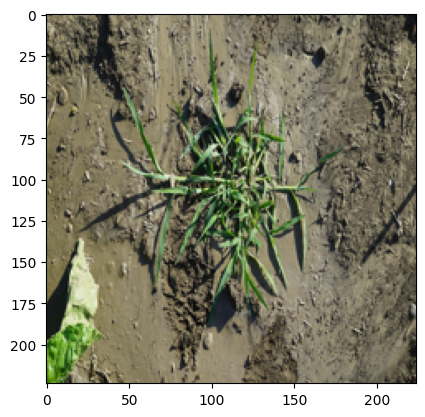

In [19]:
img_path='./dataset/images/vwg-0270-0002.jpg'
img = io.imread(img_path)
img = Image.fromarray(img).convert("RGB")
img = img.resize((224, 224))
img_tensor = F.pil_to_tensor(img) / 255.0
img_tensor = img_tensor.unsqueeze(0).to(device)
print("img_tensor shape", img_tensor.shape)

plt.imshow(img)
target_name='Sunflower'
target_class=labels.get_label_id_by_name(target_name)
print("target class", target_class)

normalized_prob_mask shape torch.Size([1, 10, 224, 224])
class_mask shape torch.Size([224, 224])

Unique values and their counts:
Value: 3, Count: 941
Value: 8, Count: 54
Value: 9, Count: 49181
class_mask_uint8 shape torch.Size([224, 224])


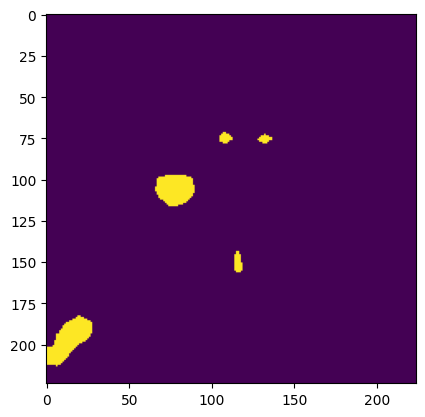

In [20]:
output=deeplabv3(img_tensor)['out']


normalized_prob_mask = torch.nn.functional.softmax(output, dim=1)
print("normalized_prob_mask shape", normalized_prob_mask.shape)

class_mask=normalized_prob_mask.argmax(dim=1)
class_mask=class_mask.squeeze(0)
print("class_mask shape", class_mask.shape)


unique_values, counts = np.unique(class_mask.cpu().numpy(), return_counts=True)
a=dict(zip(unique_values, counts))
print("\nUnique values and their counts:")
for value, count in a.items():
    print(f"Value: {value}, Count: {count}")

class_mask_uint8= 255 * (class_mask == target_class)
print("class_mask_uint8 shape", class_mask_uint8.shape)

plt.imshow(class_mask_uint8.cpu().numpy())

# plt.imshow(class_mask_uint8.cpu().numpy())



